In [1]:
import os
import logging

#Set TensorFlow logging level to suppress warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
#Set absl logging level to suppress warnings
logging.getLogger('absl').setLevel(logging.ERROR)

#Standard Data Packages
import pandas as pd
import numpy as np

#Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

#tf and keras
import tensorflow as tf
from keras import models
from keras import layers

#Scikit
from sklearn import metrics

## Load Dataset

In [2]:
train_set = pd.read_csv("../data/train_set.csv")
val_set = pd.read_csv("../data/val_set.csv")

In [3]:
features = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

X_train = train_set[features]
Y_train = train_set["Exited"]

X_val = val_set[features]
Y_val = val_set["Exited"]

In [4]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,585,france,female,53.0,2,0.00,2,1.0,1.0,91830.75
1,606,france,male,24.0,2,0.00,1,0.0,1.0,90876.95
2,633,germany,male,44.0,1,118907.60,1,1.0,0.0,47777.15
3,602,germany,male,40.0,2,149961.99,2,1.0,1.0,82696.84
4,645,france,male,31.0,4,132351.29,1,1.0,0.0,151887.16


In [5]:
X_train.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object

In [6]:
display(X_train.max(axis = 0))
display(X_train.min(axis = 0))

CreditScore              850
Geography              spain
Gender                  male
Age                     92.0
Tenure                    10
Balance            250898.09
NumOfProducts              4
HasCrCard                1.0
IsActiveMember           1.0
EstimatedSalary    199992.48
dtype: object

CreditScore           350
Geography          france
Gender             female
Age                  18.0
Tenure                  0
Balance               0.0
NumOfProducts           1
HasCrCard             0.0
IsActiveMember        0.0
EstimatedSalary     11.58
dtype: object

## MNN Experiment 1

#### Build Model with Layers: Input (CreditScore) -> 32 -> 24 -> Output

In [7]:
def build_model1(learning_rate = 0.01):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    #add input
    input = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "CreditScore")

    #create bins for input
    input_bins = np.arange(85, 851, 85)
    
    #bucket input into corresponding bucket
    input_binned = tf.keras.layers.Discretization(bin_boundaries = input_bins)(input)
    
    #create one-hot encoding for input buckets
    input_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(input_bins) + 1),
        output_mode = "one_hot")(input_binned)

    #add dense layer 1
    hidden1 = tf.keras.layers.Dense(units = 32, activation = "relu", name = "hidden1")(input_id)
    
    #add dense layer 2
    hidden2 = tf.keras.layers.Dense(units = 24, activation = "relu", name = "hidden2")(hidden1)

    #add output layer
    dx = tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "Dx")(hidden2)
    
    #configure model
    model = tf.keras.Model(inputs = input, outputs = dx, name = "model1")

    #configure optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    
    return model

#### Fit and Evaluate

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CreditScore (InputLayer)    [(None, 1)]               0         
                                                                 
 discretization (Discretizat  (None, 1)                0         
 ion)                                                            
                                                                 
 integer_lookup (IntegerLook  (None, 12)               0         
 up)                                                             
                                                                 
 hidden1 (Dense)             (None, 32)                416       
                                                                 
 hidden2 (Dense)             (None, 24)                792       
                                                                 
 Dx (Dense)                  (None, 1)                 25   

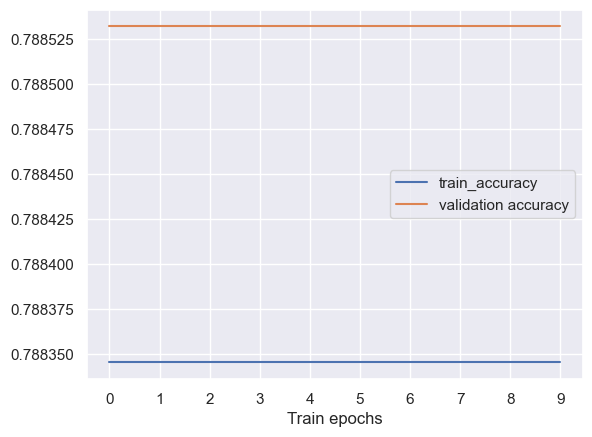

,loss,accuracy,val_loss,val_accuracy
0,0.518812,0.788345,0.515724,0.788532
1,0.515885,0.788345,0.515544,0.788532
2,0.515797,0.788345,0.515634,0.788532
3,0.515741,0.788345,0.515486,0.788532
4,0.515753,0.788345,0.515580,0.788532
5,0.515742,0.788345,0.515447,0.788532
6,0.515762,0.788345,0.515455,0.788532
7,0.515714,0.788345,0.515428,0.788532
8,0.515747,0.788345,0.515456,0.788532
9,0.515763,0.788345,0.515451,0.788532


In [8]:
num_epochs = 10

#build model
model1 = build_model1(learning_rate = 0.01)
model1.summary()

#fit model on train data and evaluate on validation data
history = model1.fit(
    x = X_train[["CreditScore"]],
    y = Y_train,
    epochs = num_epochs,
    batch_size = 32,
    validation_data = (
        X_val[["CreditScore"]],
        Y_val),
    verbose = 0)

#print and plot results
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)

#### Make Predictions and Evaluate on Validation Data

1548/1548 [==============================] - 0s 231us/step
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     39041
           1       0.00      0.00      0.00     10470

    accuracy                           0.79     49511
   macro avg       0.39      0.50      0.44     49511
weighted avg       0.62      0.79      0.70     49511



/Users/albertkao/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albertkao/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albertkao/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

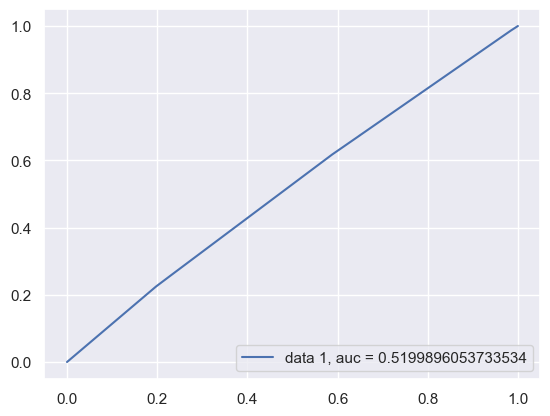

In [9]:
#make predictions
predict_val = model1.predict(X_val[["CreditScore"]])

#ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(Y_val,  predict_val)
auc = metrics.roc_auc_score(Y_val, predict_val)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

#convert probability to labels
predict_val[predict_val <= 0.5] = 0
predict_val[predict_val > 0.5] = 1

#print metrics
print(metrics.classification_report(Y_val, predict_val))

plt.show()

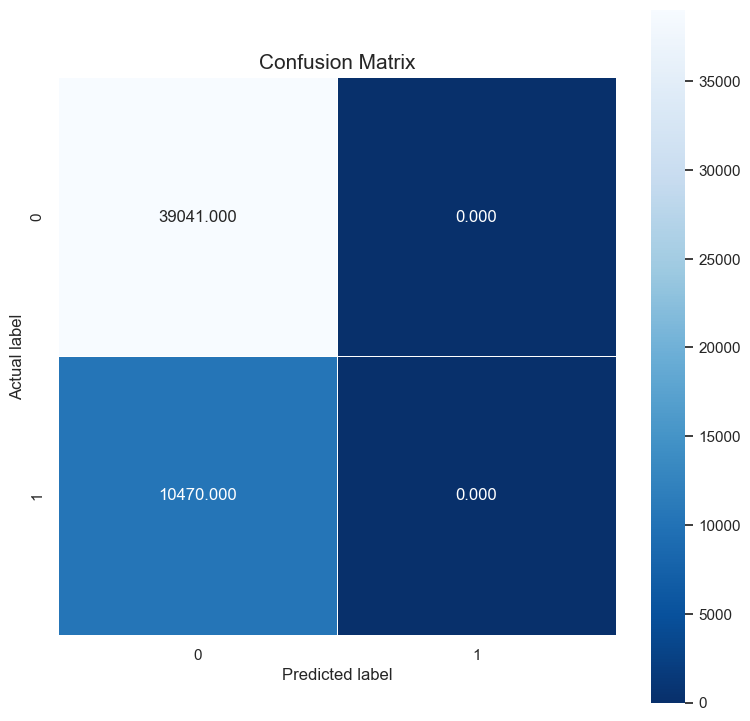

In [10]:
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize = (9,9))
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

## MNN Experiment 2

#### Build Model with Layers: Inputs (All Features) -> Process Inputs -> 32 -> 24 -> 12 -> Output

In [11]:
def build_model2(optimizer = "SGD", learning_rate = 0.01):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    #add inputs for all features
    #create bins for numerical features and one-hot encoded them
    #encode categorical features

    credit_score = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "CreditScore")
    #create bins
    credit_score_bins = np.arange((X_train.CreditScore.max(axis = 0) / 10), (X_train.CreditScore.max(axis = 0) + 1), (X_train.CreditScore.max(axis = 0) / 10))
    #put values in bins
    credit_score_binned = tf.keras.layers.Discretization(bin_boundaries = credit_score_bins)(credit_score)
    #one-hot encode
    credit_score_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(credit_score_bins) + 1),
        output_mode = "one_hot")(credit_score_binned)

    geography = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "Geography")
    geography_id = tf.keras.layers.StringLookup(vocabulary = ["spain", "france", "germany"], output_mode = "one_hot")(geography)
    
    gender = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "Gender")
    gender_id = tf.keras.layers.StringLookup(vocabulary = ["male", "female"], output_mode = "one_hot")(gender)
 
    age = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Age")
    age_bins = np.arange((X_train.Age.max(axis = 0) / 10), (X_train.Age.max(axis = 0) + 1), (X_train.Age.max(axis = 0) / 10))
    age_binned = tf.keras.layers.Discretization(bin_boundaries = age_bins)(age)
    age_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(age_bins) + 1),
        output_mode = "one_hot")(age_binned)
    
    tenure = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Tenure")
    tenure_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, (X_train.Tenure.max(axis = 0) + 1)),
        output_mode = "one_hot")(tenure)
    
    balance = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Balance")
    balance_bins = np.arange((X_train.Balance.max(axis = 0) / 10), (X_train.Balance.max(axis = 0) + 1), (X_train.Balance.max(axis = 0) / 10))
    balance_binned = tf.keras.layers.Discretization(bin_boundaries = balance_bins)(balance)
    balance_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(balance_bins) + 1),
        output_mode = "one_hot")(balance_binned)
    
    numProducts = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "NumOfProducts")
    numProducts_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, (X_train.NumOfProducts.max(axis = 0) + 1)),
        output_mode = "one_hot")(numProducts)
    
    crCard = tf.keras.layers.Input(shape = (1, ), dtype = tf.int64, name = "HasCrCard")
    crCard_id = tf.keras.layers.IntegerLookup(
        vocabulary = [0, 1],
        output_mode = "one_hot")(crCard)
    
    activeMember = tf.keras.layers.Input(shape = (1, ), dtype = tf.int64, name = "IsActiveMember")
    activeMember_id = tf.keras.layers.IntegerLookup(
        vocabulary = [0, 1],
        output_mode = "one_hot")(activeMember)
    
    salary = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "EstimatedSalary")
    salary_bins = np.arange((X_train.EstimatedSalary.max(axis = 0) / 10), (X_train.EstimatedSalary.max(axis = 0) + 1), (X_train.EstimatedSalary.max(axis = 0) / 10))
    salary_binned = tf.keras.layers.Discretization(bin_boundaries = salary_bins)(salary)
    salary_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(salary_bins) + 1),
        output_mode = "one_hot")(salary_binned)

    #concatenate all inputs
    features = tf.keras.layers.Concatenate()([credit_score_id, geography_id, gender_id, age_id, tenure_id, balance_id, numProducts_id, crCard_id, activeMember_id, salary_id])

    #add dense layer 1
    hidden1 = tf.keras.layers.Dense(units = 32, activation = "relu", name = "hidden1")(features)
    
    #add dense layer 2
    hidden2 = tf.keras.layers.Dense(units = 24, activation = "relu", name = "hidden2")(hidden1)

    #add dense layer 3
    hidden3 = tf.keras.layers.Dense(units = 12, activation = "relu", name = "hidden3")(hidden2)

    #add output layer
    dx = tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "Dx")(hidden3)
    
    #configure model
    model = tf.keras.Model(inputs = [credit_score, geography, gender, age, tenure, balance, numProducts, crCard, activeMember, salary], outputs = dx, name = "model2")

    #configure optimizer
    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == "Adam": #for testing
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    
    return model

#### Fit and Evaluate

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CreditScore (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Balance (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 EstimatedSalary (InputLayer)   [(None, 1)]          0           []                               
                                                                                             

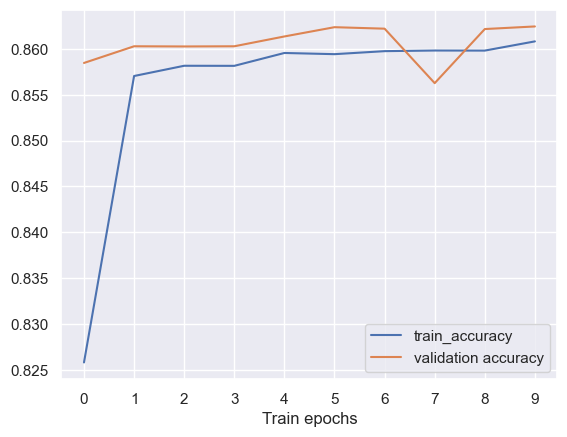

,loss,accuracy,val_loss,val_accuracy
0,0.405752,0.825810,0.336843,0.858456
1,0.338445,0.857033,0.333675,0.860273
2,0.335587,0.858149,0.333229,0.860253
3,0.333878,0.858141,0.332747,0.860273
4,0.332838,0.859543,0.330410,0.861344
5,0.331811,0.859413,0.328603,0.862354
6,0.331237,0.859742,0.328787,0.862192
7,0.330435,0.859811,0.338070,0.856254
8,0.329963,0.859803,0.327712,0.862152
9,0.329323,0.860807,0.327253,0.862435


In [12]:
#build model
model2 = build_model2(optimizer = "SGD", learning_rate = 0.01)
model2.summary()

#fit on train data and evaluate on validation data
history = model2.fit(
    x = {
        "CreditScore": X_train[["CreditScore"]],
        "Geography": X_train[["Geography"]],
        "Gender": X_train[["Gender"]],
        "Age": X_train[["Age"]],
        "Tenure": X_train[["Tenure"]],
        "Balance": X_train[["Balance"]],
        "NumOfProducts": X_train[["NumOfProducts"]],
        "HasCrCard": X_train[["HasCrCard"]],
        "IsActiveMember": X_train[["IsActiveMember"]],
        "EstimatedSalary": X_train[["EstimatedSalary"]],
    },
    y = Y_train,
    epochs = num_epochs,
    batch_size = 32,
    validation_data = (
        {
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        },
        Y_val),
    verbose = 0)

#print results
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)

#### Make Predictions and Evaluate on Validation Data

1548/1548 [==============================] - 1s 367us/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39041
           1       0.73      0.55      0.63     10470

    accuracy                           0.86     49511
   macro avg       0.81      0.75      0.77     49511
weighted avg       0.85      0.86      0.85     49511



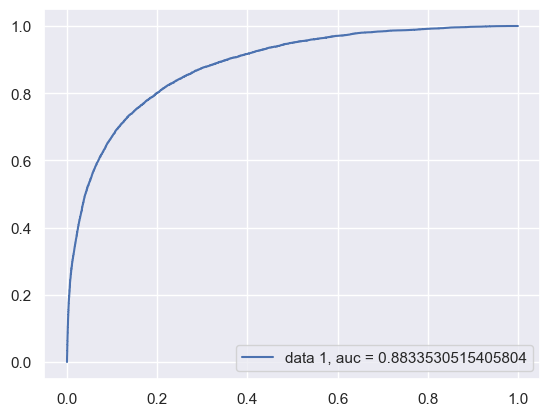

In [13]:
#make predictions
predict_val = model2.predict({
    "CreditScore": X_val[["CreditScore"]],
    "Geography": X_val[["Geography"]],
    "Gender": X_val[["Gender"]],
    "Age": X_val[["Age"]],
    "Tenure": X_val[["Tenure"]],
    "Balance": X_val[["Balance"]],
    "NumOfProducts": X_val[["NumOfProducts"]],
    "HasCrCard": X_val[["HasCrCard"]],
    "IsActiveMember": X_val[["IsActiveMember"]],
    "EstimatedSalary": X_val[["EstimatedSalary"]],
})

#ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(Y_val,  predict_val)
auc = metrics.roc_auc_score(Y_val, predict_val)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

#convert probability to labels
predict_val[predict_val <= 0.5] = 0
predict_val[predict_val > 0.5] = 1

#print metrics
print(metrics.classification_report(Y_val, predict_val))

plt.show()

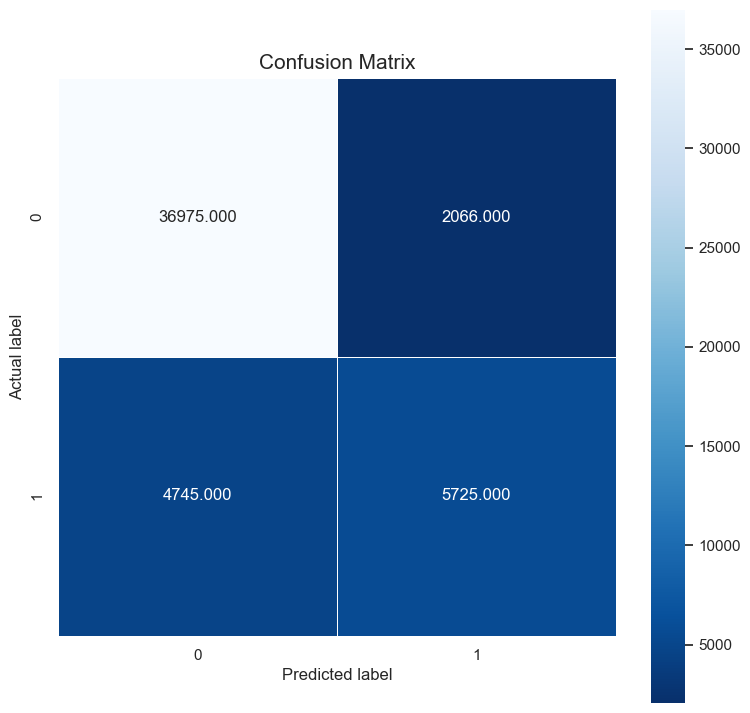

In [14]:
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize = (9,9))
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

## MNN Experiment 3

#### Build Model with Layers: Inputs (All Features) -> Process Inputs -> 64 -> 128 -> 254 -> 32 -> Output

In [15]:
def build_model3(optimizer = "SGD", learning_rate = 0.01):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    #add inputs for all features
    #create bins for numerical features and one-hot encoded them
    #encode categorical features

    credit_score = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "CreditScore")
    #create bins
    credit_score_bins = np.arange((X_train.CreditScore.max(axis = 0) / 10), (X_train.CreditScore.max(axis = 0) + 1), (X_train.CreditScore.max(axis = 0) / 10))
    #put values in bins
    credit_score_binned = tf.keras.layers.Discretization(bin_boundaries = credit_score_bins)(credit_score)
    #one-hot encode
    credit_score_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(credit_score_bins) + 1),
        output_mode = "one_hot")(credit_score_binned)

    geography = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "Geography")
    geography_id = tf.keras.layers.StringLookup(vocabulary = ["spain", "france", "germany"], output_mode = "one_hot")(geography)
    
    gender = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "Gender")
    gender_id = tf.keras.layers.StringLookup(vocabulary = ["male", "female"], output_mode = "one_hot")(gender)
 
    age = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Age")
    age_bins = np.arange((X_train.Age.max(axis = 0) / 10), (X_train.Age.max(axis = 0) + 1), (X_train.Age.max(axis = 0) / 10))
    age_binned = tf.keras.layers.Discretization(bin_boundaries = age_bins)(age)
    age_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(age_bins) + 1),
        output_mode = "one_hot")(age_binned)
    
    tenure = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Tenure")
    tenure_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, (X_train.Tenure.max(axis = 0) + 1)),
        output_mode = "one_hot")(tenure)
    
    balance = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Balance")
    balance_bins = np.arange((X_train.Balance.max(axis = 0) / 10), (X_train.Balance.max(axis = 0) + 1), (X_train.Balance.max(axis = 0) / 10))
    balance_binned = tf.keras.layers.Discretization(bin_boundaries = balance_bins)(balance)
    balance_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(balance_bins) + 1),
        output_mode = "one_hot")(balance_binned)
    
    numProducts = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "NumOfProducts")
    numProducts_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, (X_train.NumOfProducts.max(axis = 0) + 1)),
        output_mode = "one_hot")(numProducts)

    crCard = tf.keras.layers.Input(shape = (1, ), dtype = tf.int64, name = "HasCrCard")
    crCard_id = tf.keras.layers.IntegerLookup(
        vocabulary = [0, 1],
        output_mode = "one_hot")(crCard)
    
    activeMember = tf.keras.layers.Input(shape = (1, ), dtype = tf.int64, name = "IsActiveMember")
    activeMember_id = tf.keras.layers.IntegerLookup(
        vocabulary = [0, 1],
        output_mode = "one_hot")(activeMember)
    
    salary = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "EstimatedSalary")
    salary_bins = np.arange((X_train.EstimatedSalary.max(axis = 0) / 10), (X_train.EstimatedSalary.max(axis = 0) + 1), (X_train.EstimatedSalary.max(axis = 0) / 10))
    salary_binned = tf.keras.layers.Discretization(bin_boundaries = salary_bins)(salary)
    salary_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(salary_bins) + 1),
        output_mode = "one_hot")(salary_binned)

    #concatenate all inputs
    features = tf.keras.layers.Concatenate()([credit_score_id, geography_id, gender_id, age_id, tenure_id, balance_id, numProducts_id, crCard_id, activeMember_id, salary_id])

    #add dense layer 1
    hidden1 = tf.keras.layers.Dense(units = 64, activation = "relu", name = "hidden1")(features)

    #add dense layer 2
    hidden2 = tf.keras.layers.Dense(units = 128, activation = "relu", name = "hidden2")(hidden1)

    #add dense layer 3
    hidden3 = tf.keras.layers.Dense(units = 254, activation = "relu", name = "hidden4")(hidden2)

    #add dense layer 4
    hidden4 = tf.keras.layers.Dense(units = 32, activation = "relu", name = "hidden5")(hidden3)

    #add output layer
    dx = tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "Dx")(hidden4)
    
    #configure model
    model = tf.keras.Model(inputs = [credit_score, geography, gender, age, tenure, balance, numProducts, crCard, activeMember, salary], outputs = dx, name = "model2")

    #configure optimizer
    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == "Adam": #for testing
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    
    return model

## Fit and Evaluate

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CreditScore (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Balance (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 EstimatedSalary (InputLayer)   [(None, 1)]          0           []                               
                                                                                             

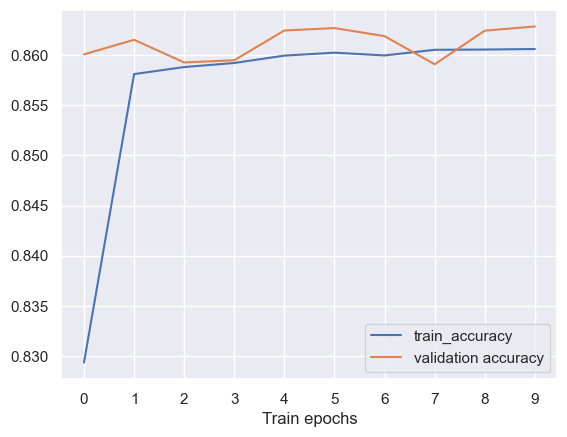

,loss,accuracy,val_loss,val_accuracy
0,0.389189,0.829333,0.334822,0.860092
1,0.336634,0.858123,0.331772,0.861546
2,0.333335,0.858825,0.334913,0.859284
3,0.331518,0.859231,0.333004,0.859506
4,0.330517,0.859967,0.328380,0.862475
5,0.329349,0.860262,0.326709,0.862717
6,0.328890,0.859985,0.328223,0.861909
7,0.328153,0.860547,0.335301,0.859102
8,0.327766,0.860573,0.326655,0.862455
9,0.327170,0.860625,0.326315,0.862879


In [16]:
#build model
model3 = build_model3(optimizer = "SGD", learning_rate = 0.01)
model3.summary()

#fit on train data and evaluate on validation data
history = model3.fit(
    x = {
        "CreditScore": X_train[["CreditScore"]],
        "Geography": X_train[["Geography"]],
        "Gender": X_train[["Gender"]],
        "Age": X_train[["Age"]],
        "Tenure": X_train[["Tenure"]],
        "Balance": X_train[["Balance"]],
        "NumOfProducts": X_train[["NumOfProducts"]],
        "HasCrCard": X_train[["HasCrCard"]],
        "IsActiveMember": X_train[["IsActiveMember"]],
        "EstimatedSalary": X_train[["EstimatedSalary"]],
    },
    y = Y_train,
    epochs = num_epochs,
    batch_size = 32,
    validation_data = (
        {
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        },
        Y_val),
    verbose = 0)

#print results
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)

#### Make Predictions and Evaluate on Validation Data

1548/1548 [==============================] - 1s 429us/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39041
           1       0.73      0.55      0.63     10470

    accuracy                           0.86     49511
   macro avg       0.81      0.75      0.77     49511
weighted avg       0.85      0.86      0.86     49511



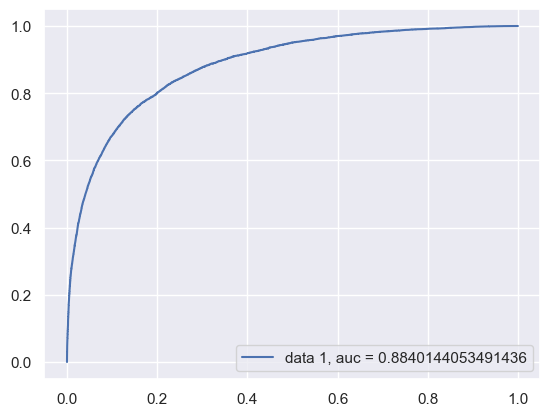

In [17]:
#make predictions
predict_val = model3.predict({
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        })

#ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(Y_val, predict_val)
auc = metrics.roc_auc_score(Y_val, predict_val)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

#convert probability to labels
predict_val[predict_val <= 0.5] = 0
predict_val[predict_val > 0.5] = 1

#print metrics
print(metrics.classification_report(Y_val, predict_val))

plt.show()

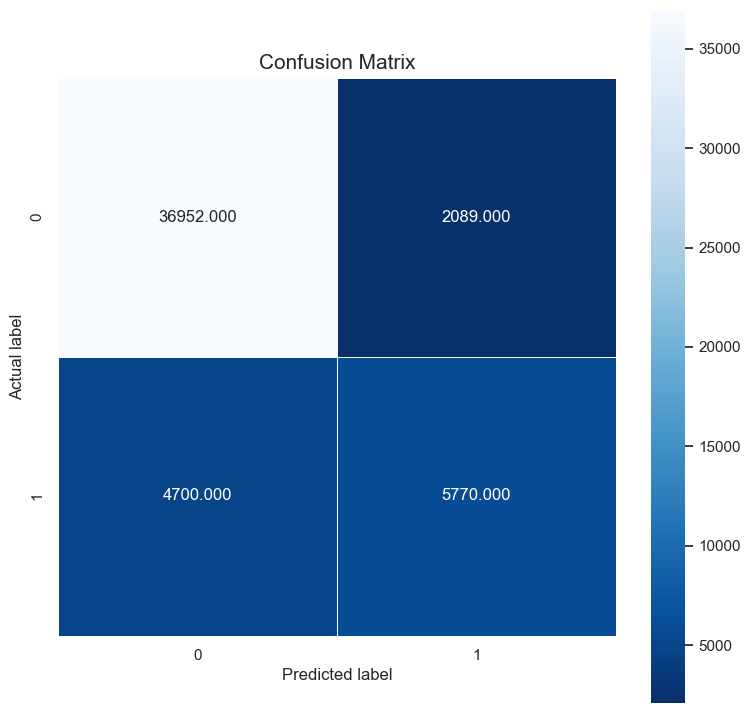

In [18]:
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

## MNN Experiment 4 (undersampled balanced dataset)

#### Load Dataset

In [19]:
train_norm_balanced = pd.read_csv('../data/train_set_balanced.csv')

X_train_balanced = train_norm_balanced[features]
Y_train_balanced = train_norm_balanced["Exited"]

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CreditScore (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Balance (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 EstimatedSalary (InputLayer)   [(None, 1)]          0           []                               
                                                                                             

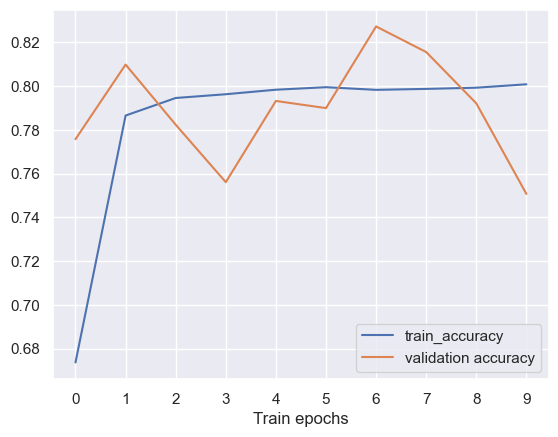

,loss,accuracy,val_loss,val_accuracy
0,0.621775,0.673694,0.475953,0.775686
1,0.460684,0.786491,0.422977,0.809780
2,0.444355,0.794507,0.466540,0.782311
3,0.439147,0.796225,0.511129,0.756054
4,0.435458,0.798290,0.441108,0.793157
5,0.433767,0.799436,0.445686,0.789885
6,0.432336,0.798229,0.391330,0.827190
7,0.431587,0.798659,0.410726,0.815496
8,0.430408,0.799211,0.442394,0.792066
9,0.429466,0.800765,0.517885,0.750682


In [20]:
#build model
model4 = build_model2(optimizer = "SGD", learning_rate = 0.01)
model4.summary()

#fit on train data and evaluate on validation data
history = model4.fit(
    x = {
        "CreditScore": X_train_balanced[["CreditScore"]],
        "Geography": X_train_balanced[["Geography"]],
        "Gender": X_train_balanced[["Gender"]],
        "Age": X_train_balanced[["Age"]],
        "Tenure": X_train_balanced[["Tenure"]],
        "Balance": X_train_balanced[["Balance"]],
        "NumOfProducts": X_train_balanced[["NumOfProducts"]],
        "HasCrCard": X_train_balanced[["HasCrCard"]],
        "IsActiveMember": X_train_balanced[["IsActiveMember"]],
        "EstimatedSalary": X_train_balanced[["EstimatedSalary"]],
    },
    y = Y_train_balanced,
    epochs = num_epochs,
    batch_size = 32,
    validation_data = (
        {
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        },
        Y_val),
    verbose = 0)

#print results
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)

#### Make Predictions and Evaluate on Validation Data

1548/1548 [==============================] - 1s 370us/step
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     39041
           1       0.45      0.86      0.59     10470

    accuracy                           0.75     49511
   macro avg       0.70      0.79      0.71     49511
weighted avg       0.85      0.75      0.77     49511



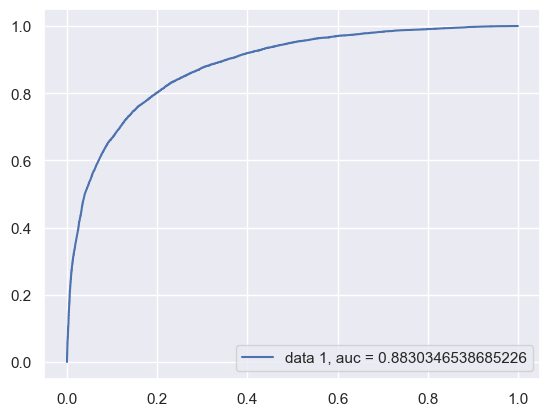

In [21]:
#make predictions
predict_val = model4.predict({
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        })

#ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(Y_val, predict_val)
auc = metrics.roc_auc_score(Y_val, predict_val)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

#convert probability to labels
predict_val[predict_val <= 0.5] = 0
predict_val[predict_val > 0.5] = 1

#print metrics
print(metrics.classification_report(Y_val, predict_val))

plt.show()

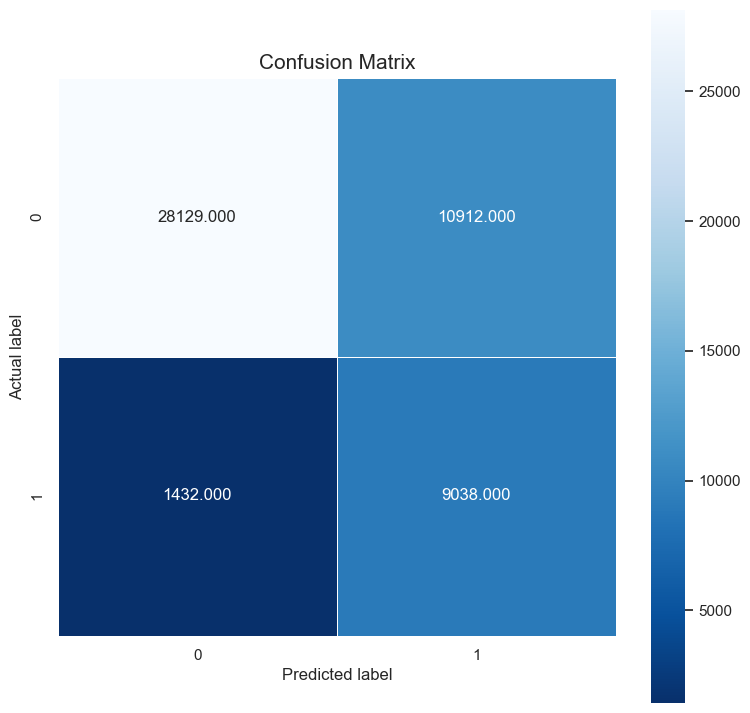

In [22]:
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize = (9,9))
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

## MNN Experiment 5 (undersampled balanced dataset)

#### Fit and Evaluate

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CreditScore (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Balance (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 EstimatedSalary (InputLayer)   [(None, 1)]          0           []                               
                                                                                             

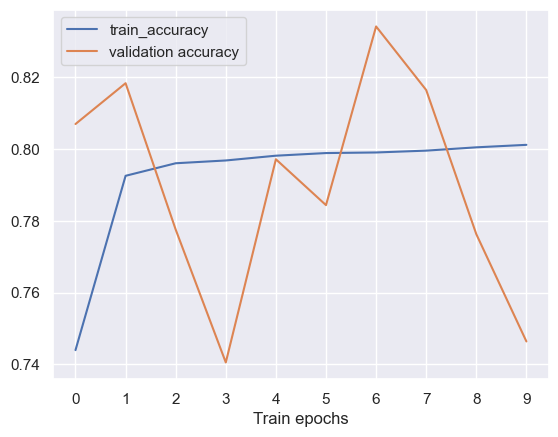

,loss,accuracy,val_loss,val_accuracy
0,0.525810,0.743978,0.425366,0.806972
1,0.445840,0.792544,0.405337,0.818343
2,0.439299,0.796041,0.472534,0.777565
3,0.436013,0.796818,0.544154,0.740543
4,0.433468,0.798147,0.436516,0.797156
5,0.432027,0.798883,0.458751,0.784371
6,0.430687,0.799047,0.382987,0.834158
7,0.429672,0.799558,0.410797,0.816445
8,0.428183,0.800479,0.470642,0.776292
9,0.427023,0.801174,0.531840,0.746400


In [23]:
#build model
model5 = build_model3(optimizer = "SGD", learning_rate = 0.01)
model5.summary()

#fit on train data and evaluate on validation data
history = model5.fit(
    x = {
        "CreditScore": X_train_balanced[["CreditScore"]],
        "Geography": X_train_balanced[["Geography"]],
        "Gender": X_train_balanced[["Gender"]],
        "Age": X_train_balanced[["Age"]],
        "Tenure": X_train_balanced[["Tenure"]],
        "Balance": X_train_balanced[["Balance"]],
        "NumOfProducts": X_train_balanced[["NumOfProducts"]],
        "HasCrCard": X_train_balanced[["HasCrCard"]],
        "IsActiveMember": X_train_balanced[["IsActiveMember"]],
        "EstimatedSalary": X_train_balanced[["EstimatedSalary"]],
    },
    y = Y_train_balanced,
    epochs = num_epochs,
    batch_size = 32,
    validation_data = (
        {
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        },
        Y_val),
    verbose = 0)

#print results
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)

#### Make Predictions and Evaluate on Validation Data

1548/1548 [==============================] - 1s 432us/step
              precision    recall  f1-score   support

           0       0.95      0.71      0.82     39041
           1       0.45      0.87      0.59     10470

    accuracy                           0.75     49511
   macro avg       0.70      0.79      0.70     49511
weighted avg       0.85      0.75      0.77     49511



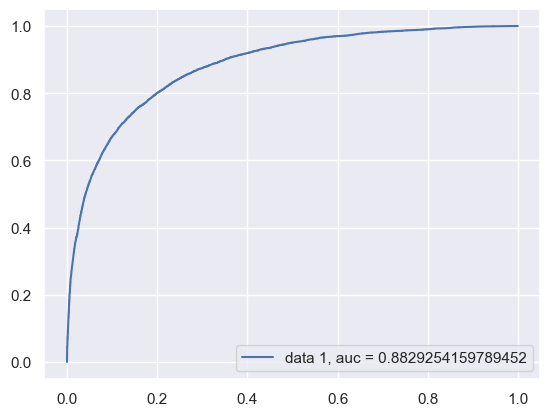

In [24]:
#make predictions
predict_val = model5.predict({
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        })

#ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(Y_val, predict_val)
auc = metrics.roc_auc_score(Y_val, predict_val)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

#convert probability to labels
predict_val[predict_val <= 0.5] = 0
predict_val[predict_val > 0.5] = 1

#print metrics
print(metrics.classification_report(Y_val, predict_val))

plt.show()

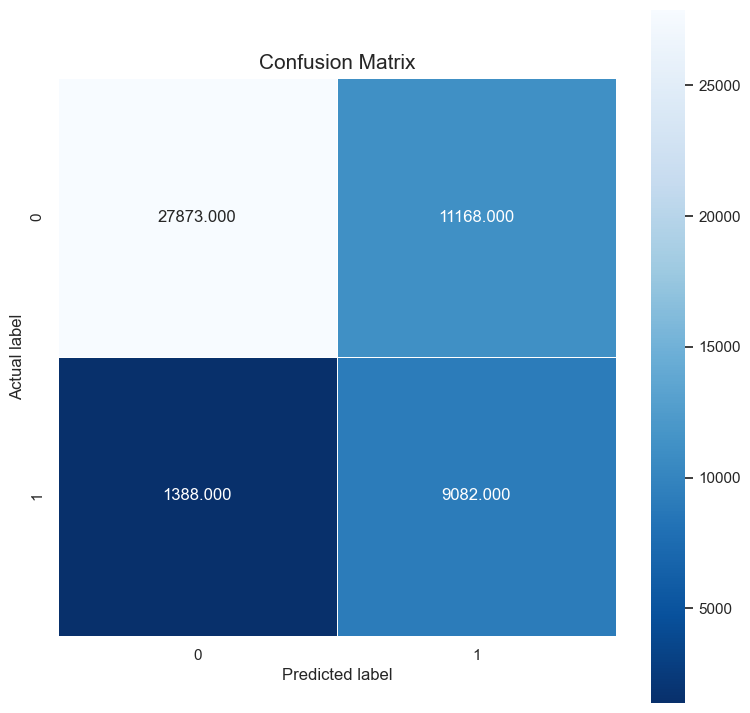

In [25]:
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize = (9,9))
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

In [27]:
model3.save("../models/mnn_discret_unbalanced.keras")
model4.save("../models/mnn_discret_balanced.keras")